In [1]:
%%time
import sys
import pandas as pd
from collections import defaultdict
import spacy
from spacy.matcher import PhraseMatcher
import math   
from spacy.util import minibatch , compounding, decaying
import random
import torch
import numpy as np
from progressbar import ProgressBar, Bar, Percentage
from sklearn.metrics import roc_auc_score
from os import listdir
from os.path import isfile, join
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from spacy_transformers.util import cyclic_triangular_rate
from thinc.neural.optimizers import Adam
from thinc.neural import Model
import matplotlib.pyplot as plt

Q:\anaconda\envs\myEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
Q:\anaconda\envs\myEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
Q:\anaconda\envs\myEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
Q:\anaconda\envs\myEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

Wall time: 48.9 s


In [2]:
%%time


train_target_full = pd.read_csv("train_target.csv")



# this part enables lPunctAgg lemmatization.
path = r"csv"
files = listdir(path)
files = [f for f in files if "Agg" in f and not ".npy" in f]
files = ["lPunctNumStopLemOovAgg.csv"]
for f in files:
    print("doing: ", f)
    #lemmed = lPunctAgg
    train_data_full = pd.read_csv(path+"\\"+f)
    print(train_data_full.head(5))
    train_data_full["body"] = train_data_full["subreddit"]+" "+train_data_full["body"]
    # print("dropping subreddits and utc")
    train_data_full.drop(["subreddit"], axis = 1, inplace = True)
    print("len(train_data_full) before elimitating empties = ",len(train_data_full), "train_data_full.loc[0,'body'] = ", train_data_full.loc[0,'body'])
    # enable following line to exclude rows with less than 4 words
    #train_data_full = train_data_full[train_data_full.body.count(" ") >3]
    #if f == "lPunctNumAgg.csv":
    train_data_full.replace(to_replace = "empty", value = "", inplace = True)
    #train_data_full = train_data_full[train_data_full.body != "empty"]
    #train_data_full = train_data_full.dropna()
    train_data_full["body"].fillna("",inplace = True)
    train_data_full.reset_index(drop  = True, inplace = True)
    print("len(train_data_full) after elimitating empties = ",len(train_data_full))
    print("creating gender...")

    ###### end of the part to be commented to avoid lPunctAgg lemmatization


    # common part to all procedures. This should never be commented

    gender = [0 for i in range(len(train_data_full))]
    print("len(gender) = ", len(gender))
    # for idx, row in train_data_full.iterrows():
    #     gender.append(train_target_full[train_target_full["author"] == row.author].iloc[0,1])
    print("gender created. Adding subreddits...")


    print("populating gender list...")
    for idx, row in train_target_full.iterrows():
        if row.gender == 1:
            #print("inside th if")
            indexes = train_data_full.index[train_data_full["author"] == row.author].tolist()
            for i in indexes:
                #print("inside the for")
                gender[i] += 1
    print("gender list polulated. Creating n_words column for future use...")
    #print(fake_gender)
    if(len(np.unique(gender) == 2)):
        train_data_full["gender"] = gender
    else:
        print("there has been an error with gender recognition, please halt the program now")

    ### end of the common part

    # useless part

    #print("gender list polulated. Creating n_words column for future use...")
    #train_data_full_sg = train_data_full.sort_values(["gender"])
    #train_data_full_sg.reset_index(inplace = True)

    #train_data_full["n_words"] = [tex.count(" ") for tex in train_data_full["body"].tolist()]
    # #rand = random.shuffle([True for t in range(split)]+[False for u in range(len(train))])


    # end of useless part

    # this is the balanced part

    train_data_full_m = train_data_full.loc[train_data_full["gender"] == 0, :]
    train_data_full_f = train_data_full.loc[train_data_full["gender"] == 1, :]

    split = math.floor(len(train_data_full_f)*1)
    
    print("split = ",split)


    seed = 100
    train_data_sample_m =  train_data_full_m.sample(n = split, random_state = seed)
    train_texts_m =train_data_sample_m["body"].tolist()
    #test_data_sample_m = train_data_full_m.drop(train_data_sample_m.index)
    #test_texts_m = test_data_sample_m["body"].tolist()

    train_data_sample_f =  train_data_full_f.sample(n = split, random_state = seed)
    train_texts_f = train_data_sample_f["body"].tolist()
    #test_data_sample_f = train_data_full_f.drop(train_data_sample_f.index)
    #test_texts_f = test_data_sample_f["body"].tolist()

    train_texts = train_texts_m + train_texts_f
    #test_texts = test_texts_m + test_texts_f

    train_labels = [{'cats': {'1': False, '0': True}} for i in range(split)] + [{'cats': {'1': True, '0': False}} for i in range(split)]
    #test_labels = [0 for i in range(len(train_data_full_m)-split)] + [1 for i in range(len(train_data_full_f)-split)]

    #train_labels_reg = [0 for i in range(split)] + [1 for j in range(split)]

    #train_texts , train_labels_reg = shuffle(train_texts , train_labels_reg , random_state = 0)

    # end of balanced part

    # unbalanced part

#     seed = 100
#     split = math.floor(len(train_data_full)*0.8)
#     print("split = ",split)

    #train_df = train_data_full
    #test_df = train_data_full.drop(train_df.index)

    #train_texts  = train_df["body"].tolist()
    #test_texts =  test_df["body"].tolist()

#     train_labels = [{'cats': {'1': label == 1,'0': label == 0}} for label in train_df["gender"].tolist()]
    #test_labels = [i for i in test_df["gender"].tolist()]  #[0 for i in range(len(train_data_full_m)-split)] + [1 for i in range(len(train_data_full_f)-split)]

#     # end of unbalanced part


#     # common part to all approaches : do not comment

    print("len(train_texts) = ",len(train_texts))



    train_data  = list(zip(train_texts, train_labels))
    #print("len(test_texts) == len(test_labels) : ", len(test_texts) == len(test_labels) )
    print("len(train_data) = ",len(train_data))

    # end of common part to all approaches


    # carica un learner che parla inglese
    nlp = spacy.blank("en")

    # Create the TextCategorizer with exclusive classes and "bow" (bag of words) architecture.
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe(
                      "textcat",
                      config={"exclusive_classes": True, "architecture": "ensemble"}) #https://github.com/explosion/spaCy/issues/3611 #, "n_gram_size" : 2, "attr": "lower"  #"softmax_last_hidden"
        nlp.add_pipe(textcat)
    else:
        textcat = nlp.get_pipe('textcat')

    # create labels (do they coomute)
    textcat.add_label("1")
    textcat.add_label("0")


    # add the textcat to the spacy pipe

    #nlp.add_pipe(textcat)


    # %%time

    random.seed(1)
    spacy.util.fix_random_seed(1)

    # write it otherwise it is not happy
    nlp.vocab.vectors.name = 'spacy_pretrained_vectors'

    # speaks for itself
    print("random seeds set")
    name = f.replace(".csv","")
    losses = {}
    rocs = []
    run_title = "bow_bal_"+name
    output = ""

    print("strings and lists initialized")
    dec = decaying(0.2 , 0.0, 2e-4)

    #learning process
    #for batch_size in [10, 50, 100, 200, 300] : 
    pipe_exceptions = ['textcat'] #("trf_wordpiecer", "trf_tok2vec) are required, #https://github.com/explosion/spaCy/blob/master/examples/training/train_textcat.py
    print("pipe_exceptions defined")
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    print("other_pipes defined")
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
#         batch_size  = 4
#         learn_rate = 0.001 #0.0005
#         learn_rates = cyclic_triangular_rate(learn_rate / 3, learn_rate * 3, 2 * len(train_data) // batch_size)
#         nlp.begin_training()
#         ops = Model.ops
#         beta1 = 0.9 #0.9
#         beta2 = 0.999 #0.999
#         eps = 1e-10 #1e-8
#         L2 = 0.0 #1e-6
#         max_grad_norm = 1 #1.0
#         optimizer = Adam(ops, learn_rate, L2=L2, beta1=beta1, beta2=beta2, eps=eps)
#         optimizer.max_grad_norm = max_grad_norm
#         optimizer.device = ops.device
        for epoch in range(15):
            random.shuffle(train_data)
            print("data shuffled")
            # Create the batch generator with batch size = 8
            #optimizer.learn_rate = float(next(learn_rates))
            batches = minibatch(train_data, size = compounding(4., 32., 1.001) )  #batch_size
            print("batches created")
            # Iterate through minibatches
            pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=556).start()  #8387 is the total number of iterations needed for an unbalanced 0.8 trainset. 0.04 of unbalanced would be approx 1540 . 4595 for lemmatized balanced. 8420 for lemmatized unbalanced
            i = 0                                                                    # 737 for lPunctAgg and lPunctNumAgg unbalanced, 466 for balanced
            for batch in batches:
                # Each batch is a list of (text, label) but we need to
                # send separate lists for texts and labels to update().
                # This is a quick way to split a list of tuples into lists
                texts1, labels = zip(*batch)
                # print("updating")
                #print("len(texts1) = ",len(texts1), "len(labels) = ",len(labels), "texts1 =", texts1, "labels = ", labels  )
                nlp.update(texts1, labels, sgd=optimizer, losses=losses, drop = next(dec))
                i += 1
                pbar.update(i)
            pbar.finish()
            print("i = ",  i)
#                 rocs.append(evaluate_roc(nlp, textcat))
#                 output += f"    epoch = {epoch}, losses = {losses}, roc = {rocs[-1]} \n "
#                 print( "epoch = ",epoch," losses = ", losses, "roc = " , rocs[-1] , "i = ", i)
    
    
#     docs = [nlp.tokenizer(tex) for tex in test_texts]
#     #textcat = nlp.get_pipe("textcat")
#     scores , a = textcat.predict(docs) 
#     pred_y= [b[0] for b in scores] #[1 if b[0] > b[1] else 0 for b in scores]
#     roc = roc_auc_score(test_labels, y_pred)
#     print(roc)
    


#     df_res = pd.DataFrame({"author": test_df["author"].tolist(), "pred_y" : y_pred, "true_y" : test_labels  })
#     df_res.to_csv (r'Q:\tooBigToDrive\data-mining\kaggle\my_models\spaCy\results\finals\csv\bodies.csv', index = False, header=True)
#     with textcat.model.use_params(optimizer.averages):
#         nlp.to_disk(r'Q:\tooBigToDrive\data-mining\kaggle\my_models\spaCy\savedModels\bodieswS_bal')  




doing:  lPunctNumStopLemOovAgg.csv
           author                                          subreddit  \
0          -Jared                       starwars askreddit pics tall   
1         -Peeter                                             gainit   
2        -evasian  mousereview askreddit mechanicalkeyboards jail...   
3         -rubiks                                    askwomen askmen   
4  -true_neutral-                    todayilearned mildlyinteresting   

                                                body  
0  neil diamond sweet caroline chiropractor go re...  
1                                           read faq  
2  receive deathadder black edition yesterday try...  
3  best monkey d haight floyd great gig bank like...  
4  gt urban ear different pair month different pr...  
len(train_data_full) before elimitating empties =  5000 train_data_full.loc[0,'body'] =  starwars askreddit pics tall neil diamond sweet caroline chiropractor go religiously age extreme low pain run tra

random seeds set
strings and lists initialized
pipe_exceptions defined
other_pipes defined
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


100%|#########################################################################|


i =  555
data shuffled
batches created


i =  555
Wall time: 46min 56s


In [3]:
#nlp = spacy.load(r'Q:\tooBigToDrive\data-mining\kaggle\my_models\spaCy\savedModels\bodieswS_bal')
print("loaded nlp")
textcat = nlp.get_pipe("textcat")
print("obtained textcat")
df = pd.read_csv(r"Q:\tooBigToDrive\data-mining\kaggle\my_models\spaCy\results\finals\csv\test\\"+"lPunctNumStopLemOovAggTest.csv")
print("loaded df")
series = df["subreddit"]+" "+df["body"] 
print(type(series), len(series))
l = series.values
print(len(l), l[0])
docs = [] #nlp.tokenizer(str(tex)) for tex in l
pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=len(l)).start()
i = 0
for tex in l:
    docs.append(nlp.tokenizer(str(tex)))
    i += 1
    pbar.update(i)
pbar.finish()
print("docs done", len(docs))
pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=len(docs)).start()
# scores, a = textcat.predict(docs)
i = 0
scores = []
for doc in docs:
    scores.append(textcat.predict([doc])[0])
    i += 1
    pbar.update(i)
pbar.finish()
print("done")
print(scores[0])
pred_y = [v[0][0] for v in scores]
print(pred_y[0])
bodieswS_test_predictions = pd.DataFrame({"author": df["author"].tolist(), "pred_y": pred_y})
print(bodieswS_test_predictions.head(5))



bodieswS_test_predictions.to_csv(r"Q:\tooBigToDrive\data-mining\kaggle\my_models\spaCy\results\finals\csv\test\bodieswS_bal_test_predictions")

loaded nlp
obtained textcat


loaded df
<class 'pandas.core.series.Series'> 15000
15000 insightfulquestions glasgow youshouldknow iama askreddit britishproblems get master degree exactly unexpected positive come lose hearing glass half hi brownish pubis bright blonde eyebrow be sure relevant hear earn £ happy go k k year notice huge change life style afford nice thing happy not drastic change clearly millionaire buy nice car huge house not happy person k accord theory say shite go make million comparatively measly ki suppose relative make comment kind redundant oh look play pie pint think oran mor big converted church west end near botanic garden week fortnight pie pint beer whilst watch local play £ token black man group friend


100%|#########################################################################|


docs done 15000


100%|#########################################################################|


done
[[1.0557201e-04 9.9989438e-01]]
0.00010557201
           author    pred_y
0    --redbeard--  0.000106
1       -Allaina-  0.800658
2  -AllonsyAlonso  0.117949
3          -Beth-  0.600263
4        -Greeny-  0.938785


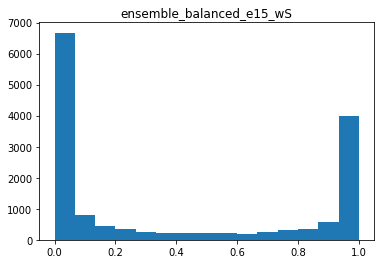

In [4]:
name = "ensemble_balanced_e15_wS"
plt.hist(pred_y, bins="auto")
plt.title(name)
plt.savefig(r"\images\\"+name+".png")
plt.show()